In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('float_format', '{:f}'.format)
import numpy as np
import time
import pickle
import joblib

# models to test
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# metrics and tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# plot lib
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

# warnings handling
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings


In [2]:
data = pd.read_csv('nouveaux_datasets/df_model_inner_221201.csv')
data.head(2)

C:\Users\Christophe\AppData\Local\Temp\ipykernel_17012\3339209625.py:1: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('nouveaux_datasets/df_model_inner_221201.csv')


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0_x,index,valeur_fonciere,adresse_numero,adresse_nom_voie,nom_commune,id_parcelle,type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,year,month,trim,index_prix,tuple_gps,closest_school_(m),closest_school_position,closest_bakery_(m),closest_bakery_position,closest_supermarket_(m),closest_supermarket_position,closest_metro_(m),closest_metro_position,closest_tram_(m),closest_tram_position,code_postal,adresse,geokey,Unnamed: 0_y,annee_dpe,diag_dpe,type_bat_dpe,annee_construction_dpe,surface_habitable_dpe,num_rue_dpe,rue_dpe,code_postal_dpe,etage_dpe,nbe_niveaux_dpe,orientation_dpe,adresse_dpe
0,0,6,14396,94225,19222288.000000,12.000000,RUE DE LA REPUBLIQUE,Lyon 2e Arrondissement,69382000AB0050,Appartement,24.000000,1.000000,4.835576,45.765109,2019,7,2019-T3,4.000000,"(45.765109, 4.835576)",150.890000,"(45.7654990924134, 4.83371292252651)",195.900000,"(45.7642568003775, 4.8333657)",39.800000,"(45.7650821003774, 4.8360876)",191.720000,"(45.763393, 4.835816)",875.260000,"(45.75888, 4.842474)",69002,12 RUE DE LA REPUBLIQUE,69382_6005_00012,35706,2022,D,appartement,1947.000000,24.500000,12,Rue de la République,69002,5.000000,1.000000,NaN,12 Rue de la République
1,1,7,14393,94222,19222288.000000,12.000000,RUE DE LA REPUBLIQUE,Lyon 2e Arrondissement,69382000AB0050,Appartement,24.000000,1.000000,4.835576,45.765109,2019,7,2019-T3,4.000000,"(45.765109, 4.835576)",150.890000,"(45.7654990924134, 4.83371292252651)",195.900000,"(45.7642568003775, 4.8333657)",39.800000,"(45.7650821003774, 4.8360876)",191.720000,"(45.763393, 4.835816)",875.260000,"(45.75888, 4.842474)",69002,12 RUE DE LA REPUBLIQUE,69382_6005_00012,35706,2022,D,appartement,1947.000000,24.500000,12,Rue de la République,69002,5.000000,1.000000,NaN,12 Rue de la République


## FEATURE ENGINEERING + SELECTION + CLEANING

In [3]:
data['prix_metre_carres'] = data['valeur_fonciere'] / data['surface_reelle_bati']
data['log_val_fon'] = data['valeur_fonciere'].apply(lambda x : np.log(x))

In [4]:
surface_max = 185.0
surface_min = 15.0
prix_max = 1200000.0
prix_min = 4000.0
prix_m2_max = 8000.0
prix_m2_mini = 1200.0

data = data[data['surface_reelle_bati'] < surface_max]
data = data[data['surface_reelle_bati'] > surface_min]
data = data[data['valeur_fonciere'] < prix_max]
data = data[data['valeur_fonciere'] > prix_min]
data = data[data['prix_metre_carres']<prix_m2_max]
data = data[data['prix_metre_carres']>prix_m2_mini]

In [5]:
data['nom_commune'].value_counts()

Lyon 3e Arrondissement     6240
Lyon 7e Arrondissement     5657
Lyon 8e Arrondissement     4180
Lyon 9e Arrondissement     3201
Lyon 5e Arrondissement     2681
Lyon 6e Arrondissement     2482
Lyon 4e Arrondissement     2073
Lyon 1er Arrondissement    1770
Lyon 2e Arrondissement     1627
Name: nom_commune, dtype: int64

In [6]:
list_diag_dpe_int = []

for value in data['diag_dpe']:
    if value == 'A':
        list_diag_dpe_int.append(6)
    elif value == 'B':
        list_diag_dpe_int.append(5)
    elif value == 'C':
        list_diag_dpe_int.append(4)
    elif value == 'D':
        list_diag_dpe_int.append(3)
    elif value == 'E':
        list_diag_dpe_int.append(2)
    elif value == 'F':
        list_diag_dpe_int.append(1)
    elif value == 'G':
        list_diag_dpe_int.append(0)

data['diag_dpe_int'] = list_diag_dpe_int

In [7]:
list_to_replace_arrdt = []

for value in data['nom_commune']:
    if value == 'Lyon 1er Arrondissement':
        list_to_replace_arrdt.append(1)
    elif value == 'Lyon 2e Arrondissement':
        list_to_replace_arrdt.append(2)
    elif value == 'Lyon 3e Arrondissement':
        list_to_replace_arrdt.append(3)
    elif value == 'Lyon 4e Arrondissement':
        list_to_replace_arrdt.append(4)
    elif value == 'Lyon 5e Arrondissement':
        list_to_replace_arrdt.append(5)
    elif value == 'Lyon 6e Arrondissement':
        list_to_replace_arrdt.append(6)
    elif value == 'Lyon 7e Arrondissement':
        list_to_replace_arrdt.append(7)
    elif value == 'Lyon 8e Arrondissement':
        list_to_replace_arrdt.append(8)
    elif value == 'Lyon 9e Arrondissement':
        list_to_replace_arrdt.append(9)

data['arrdt_int'] = list_to_replace_arrdt

In [8]:
data.head(5)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0_x,index,valeur_fonciere,adresse_numero,adresse_nom_voie,nom_commune,id_parcelle,type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,year,month,trim,index_prix,tuple_gps,closest_school_(m),closest_school_position,closest_bakery_(m),closest_bakery_position,closest_supermarket_(m),closest_supermarket_position,closest_metro_(m),closest_metro_position,closest_tram_(m),closest_tram_position,code_postal,adresse,geokey,Unnamed: 0_y,annee_dpe,diag_dpe,type_bat_dpe,annee_construction_dpe,surface_habitable_dpe,num_rue_dpe,rue_dpe,code_postal_dpe,etage_dpe,nbe_niveaux_dpe,orientation_dpe,adresse_dpe,prix_metre_carres,log_val_fon,diag_dpe_int,arrdt_int
29,29,13443,31610,200724,399000.000000,4.000000,RUE FIOL,Lyon 3e Arrondissement,69383000BK0042,Appartement,65.000000,3.000000,4.874037,45.749183,2020,12,2020-T4,6.400000,"(45.749183, 4.874037)",180.360000,"(45.7477430588023, 4.87296695960363)",119.650000,"(45.7502584003794, 4.8739828)",628.590000,"(45.7443009003803, 4.8699531)",457.730000,"(45.745395, 4.871728)",585.280000,"(45.752938, 4.868751)",69003,4 RUE FIOL,69383_2775_00004,37269,2022,C,appartement,2013.000000,42.900000,4,Rue Fiol,69003,NaN,1.000000,NaN,4 Rue Fiol,6138.461538,12.896717,4,3
30,30,17790,51439,442000,368100.000000,4.000000,RUE FIOL,Lyon 3e Arrondissement,69383000BK0042,Appartement,66.000000,3.000000,4.874037,45.749183,2022,6,2022-T2,4.500000,"(45.749183, 4.874037)",180.360000,"(45.7477430588023, 4.87296695960363)",119.650000,"(45.7502584003794, 4.8739828)",628.590000,"(45.7443009003803, 4.8699531)",457.730000,"(45.745395, 4.871728)",585.280000,"(45.752938, 4.868751)",69003,4 RUE FIOL,69383_2775_00004,37269,2022,C,appartement,2013.000000,42.900000,4,Rue Fiol,69003,NaN,1.000000,NaN,4 Rue Fiol,5577.272727,12.816110,4,3
31,31,18025,30989,199159,383330.000000,4.000000,RUE FIOL,Lyon 3e Arrondissement,69383000BK0042,Appartement,69.000000,3.000000,4.874037,45.749183,2020,10,2020-T4,6.400000,"(45.749183, 4.874037)",180.360000,"(45.7477430588023, 4.87296695960363)",119.650000,"(45.7502584003794, 4.8739828)",628.590000,"(45.7443009003803, 4.8699531)",457.730000,"(45.745395, 4.871728)",585.280000,"(45.752938, 4.868751)",69003,4 RUE FIOL,69383_2775_00004,37269,2022,C,appartement,2013.000000,42.900000,4,Rue Fiol,69003,NaN,1.000000,NaN,4 Rue Fiol,5555.507246,12.856652,4,3
32,32,29364,45129,375122,190000.000000,4.000000,RUE FIOL,Lyon 3e Arrondissement,69383000BK0042,Appartement,42.000000,2.000000,4.874037,45.749183,2017,8,2017-T3,4.500000,"(45.749183, 4.874037)",180.360000,"(45.7477430588023, 4.87296695960363)",119.650000,"(45.7502584003794, 4.8739828)",628.590000,"(45.7443009003803, 4.8699531)",457.730000,"(45.745395, 4.871728)",585.280000,"(45.752938, 4.868751)",69003,4 RUE FIOL,69383_2775_00004,37269,2022,C,appartement,2013.000000,42.900000,4,Rue Fiol,69003,NaN,1.000000,NaN,4 Rue Fiol,4523.809524,12.154779,4,3
74,74,8254,24576,181634,580000.000000,NaN,BD DE LA CROIX ROUSSE,Lyon 1er Arrondissement,69381000AB0249,Appartement,73.000000,3.000000,4.818943,45.771945,2020,7,2020-T3,6.600000,"(45.771945, 4.818943)",146.550000,"(45.7711688655222, 4.81741593542118)",222.080000,"(45.7725246003763, 4.8216831)",773.040000,"(45.7756651003759, 4.8273632)",1046.720000,"(45.774371, 4.831983)",2332.850000,"(45.75888, 4.842474)",69001,<NA> BD DE LA CROIX ROUSSE,0,25100,2022,C,appartement,1947.000000,59.400000,NaN,NaN,69007,1.000000,1.000000,NaN,nan nan,7945.205479,13.270783,4,1


In [9]:
print(data.shape)
data = data.drop_duplicates(subset=['adresse_numero','adresse_nom_voie','surface_reelle_bati', 'year', 'month', 'trim'])
print(data.shape)

(29911, 49)
(28799, 49)


In [10]:
list_categorie = []

for value in data['valeur_fonciere']:
    if value <= 25000.0:
        list_categorie.append('categorie_<=_25k')
    elif value <= 50000.0:
        list_categorie.append('categorie_btw25_and_50k')
    elif value <= 80000.0:
        list_categorie.append('categorie_btw50_and_80k')
    elif value <= 100000.0:
        list_categorie.append('categorie_btw80_and_100k')
    elif value <= 150000.0:
        list_categorie.append('categorie_btw100_and_150k')
    elif value <= 200000.0:
        list_categorie.append('categorie_btw150_and_200k')
    elif value <= 250000.0:
        list_categorie.append('categorie_btw200_and_250k')
    elif value <= 300000.0:
        list_categorie.append('categorie_btw250_and_300k')
    elif value <= 350000.0:
        list_categorie.append('categorie_btw300_and_350k')
    elif value <= 400000.0:
        list_categorie.append('categorie_btw350_and_400k')
    elif value <= 500000.0:
        list_categorie.append('categorie_btw400_and_500k')
    elif value <= 600000.0:
        list_categorie.append('categorie_btw500_and_600k')
    elif value <= 800000.0:
        list_categorie.append('categorie_btw600_and_800k')
    elif value <= 1000000.0:
        list_categorie.append('categorie_btw800_and_1M')
    elif value <= 1200000.0:
        list_categorie.append('categorie_btw1M_and_1M2')
    else:
        list_categorie.append('categorie_>_1.2M')


data['valeur_fonciere_categorie'] = list_categorie

In [11]:
list_m2_categorie = []

for value in data['prix_metre_carres']:
    if value <= 2000.0:
        list_m2_categorie.append('m2_categorie_<=_2k')
    elif value <= 3000.0:
        list_m2_categorie.append('m2_categorie_<=_3k')
    elif value <= 4000.0:
        list_m2_categorie.append('m2_categorie_<=_4k')
    elif value <= 5000.0:
        list_m2_categorie.append('m2_categorie_<=_5k')
    elif value <= 6000.0:
        list_m2_categorie.append('m2_categorie_<=_6k')
    elif value <= 7000.0:
        list_m2_categorie.append('m2_categorie_<=_7k')
    elif value <= 8000.0:
        list_m2_categorie.append('m2_categorie_<=_8k')
    else:
        list_m2_categorie.append('categorie_>_8k')

data['m2_categorie'] = list_m2_categorie

## VISUALISATION + EDA

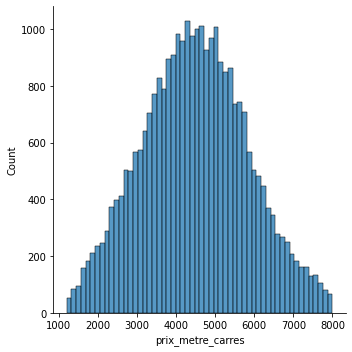

In [13]:
sns.displot(data=data['prix_metre_carres'])

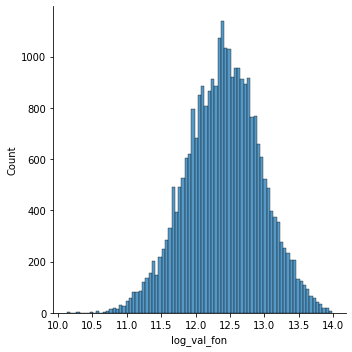

In [14]:
sns.displot(data=data['log_val_fon'])

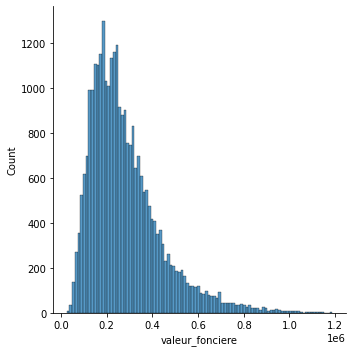

In [15]:
sns.displot(data=data['valeur_fonciere'])

In [16]:
# Basic stats
print("Number of rows : {}".format(data.shape[0]))
print()

print("Display of dataset: ")
display(data.head())
print()

print("Basics statistics: ")
data_desc = data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])


Number of rows : 28799

Display of dataset: 


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0_x,index,valeur_fonciere,adresse_numero,adresse_nom_voie,nom_commune,id_parcelle,type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,year,month,trim,index_prix,tuple_gps,closest_school_(m),closest_school_position,closest_bakery_(m),closest_bakery_position,closest_supermarket_(m),closest_supermarket_position,closest_metro_(m),closest_metro_position,closest_tram_(m),closest_tram_position,code_postal,adresse,geokey,Unnamed: 0_y,annee_dpe,diag_dpe,type_bat_dpe,annee_construction_dpe,surface_habitable_dpe,num_rue_dpe,rue_dpe,code_postal_dpe,etage_dpe,nbe_niveaux_dpe,orientation_dpe,adresse_dpe,prix_metre_carres,log_val_fon,diag_dpe_int,arrdt_int,valeur_fonciere_categorie,m2_categorie
29,29,13443,31610,200724,399000.000000,4.000000,RUE FIOL,Lyon 3e Arrondissement,69383000BK0042,Appartement,65.000000,3.000000,4.874037,45.749183,2020,12,2020-T4,6.400000,"(45.749183, 4.874037)",180.360000,"(45.7477430588023, 4.87296695960363)",119.650000,"(45.7502584003794, 4.8739828)",628.590000,"(45.7443009003803, 4.8699531)",457.730000,"(45.745395, 4.871728)",585.280000,"(45.752938, 4.868751)",69003,4 RUE FIOL,69383_2775_00004,37269,2022,C,appartement,2013.000000,42.900000,4,Rue Fiol,69003,NaN,1.000000,NaN,4 Rue Fiol,6138.461538,12.896717,4,3,categorie_btw350_and_400k,m2_categorie_<=_7k
30,30,17790,51439,442000,368100.000000,4.000000,RUE FIOL,Lyon 3e Arrondissement,69383000BK0042,Appartement,66.000000,3.000000,4.874037,45.749183,2022,6,2022-T2,4.500000,"(45.749183, 4.874037)",180.360000,"(45.7477430588023, 4.87296695960363)",119.650000,"(45.7502584003794, 4.8739828)",628.590000,"(45.7443009003803, 4.8699531)",457.730000,"(45.745395, 4.871728)",585.280000,"(45.752938, 4.868751)",69003,4 RUE FIOL,69383_2775_00004,37269,2022,C,appartement,2013.000000,42.900000,4,Rue Fiol,69003,NaN,1.000000,NaN,4 Rue Fiol,5577.272727,12.816110,4,3,categorie_btw350_and_400k,m2_categorie_<=_6k
31,31,18025,30989,199159,383330.000000,4.000000,RUE FIOL,Lyon 3e Arrondissement,69383000BK0042,Appartement,69.000000,3.000000,4.874037,45.749183,2020,10,2020-T4,6.400000,"(45.749183, 4.874037)",180.360000,"(45.7477430588023, 4.87296695960363)",119.650000,"(45.7502584003794, 4.8739828)",628.590000,"(45.7443009003803, 4.8699531)",457.730000,"(45.745395, 4.871728)",585.280000,"(45.752938, 4.868751)",69003,4 RUE FIOL,69383_2775_00004,37269,2022,C,appartement,2013.000000,42.900000,4,Rue Fiol,69003,NaN,1.000000,NaN,4 Rue Fiol,5555.507246,12.856652,4,3,categorie_btw350_and_400k,m2_categorie_<=_6k
32,32,29364,45129,375122,190000.000000,4.000000,RUE FIOL,Lyon 3e Arrondissement,69383000BK0042,Appartement,42.000000,2.000000,4.874037,45.749183,2017,8,2017-T3,4.500000,"(45.749183, 4.874037)",180.360000,"(45.7477430588023, 4.87296695960363)",119.650000,"(45.7502584003794, 4.8739828)",628.590000,"(45.7443009003803, 4.8699531)",457.730000,"(45.745395, 4.871728)",585.280000,"(45.752938, 4.868751)",69003,4 RUE FIOL,69383_2775_00004,37269,2022,C,appartement,2013.000000,42.900000,4,Rue Fiol,69003,NaN,1.000000,NaN,4 Rue Fiol,4523.809524,12.154779,4,3,categorie_btw150_and_200k,m2_categorie_<=_5k
74,74,8254,24576,181634,580000.000000,NaN,BD DE LA CROIX ROUSSE,Lyon 1er Arrondissement,69381000AB0249,Appartement,73.000000,3.000000,4.818943,45.771945,2020,7,2020-T3,6.600000,"(45.771945, 4.818943)",146.550000,"(45.7711688655222, 4.81741593542118)",222.080000,"(45.7725246003763, 4.8216831)",773.040000,"(45.7756651003759, 4.8273632)",1046.720000,"(45.774371, 4.831983)",2332.850000,"(45.75888, 4.842474)",69001,<NA> BD DE LA CROIX ROUSSE,0,25100,2022,C,appartement,1947.000000,59.400000,NaN,NaN,69007,1.000000,1.000000,NaN,nan nan,7945.205479,13.270783,4,1,categorie_btw500_and_600k,m2_categorie_<=_8k



Basics statistics: 


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0_x,index,valeur_fonciere,adresse_numero,adresse_nom_voie,nom_commune,id_parcelle,type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,year,month,trim,index_prix,tuple_gps,closest_school_(m),closest_school_position,closest_bakery_(m),closest_bakery_position,closest_supermarket_(m),closest_supermarket_position,closest_metro_(m),closest_metro_position,closest_tram_(m),closest_tram_position,code_postal,adresse,geokey,Unnamed: 0_y,annee_dpe,diag_dpe,type_bat_dpe,annee_construction_dpe,surface_habitable_dpe,num_rue_dpe,rue_dpe,code_postal_dpe,etage_dpe,nbe_niveaux_dpe,orientation_dpe,adresse_dpe,prix_metre_carres,log_val_fon,diag_dpe_int,arrdt_int,valeur_fonciere_categorie,m2_categorie
count,28799.000000,28799.000000,28799.000000,28799.000000,28799.000000,28494.000000,28799,28799,28799,28799,28799.000000,28799.000000,28799.000000,28799.000000,28799.000000,28799.000000,28799,28799.000000,28799,28799.000000,28799,28799.000000,28799,28799.000000,28799,28799.000000,28799,28799.000000,28799,28799.000000,28799,28799,28799.000000,28799.000000,28799,27993,28799.000000,28732.000000,27503,28219,28799.000000,19291.000000,28698.000000,0.000000,28799,28799.000000,28799.000000,28799.000000,28799.000000,28799,28799
unique,NaN,NaN,NaN,NaN,NaN,NaN,1075,9,5261,2,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,5261,NaN,342,NaN,275,NaN,153,NaN,35,NaN,54,NaN,6551,6311,NaN,NaN,7,5,NaN,NaN,346,1267,NaN,NaN,NaN,NaN,6311,NaN,NaN,NaN,NaN,15,7
top,NaN,NaN,NaN,NaN,NaN,NaN,RUE GARIBALDI,Lyon 3e Arrondissement,69385000BC0024,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,2021-T3,NaN,"(45.757444, 4.786061)",NaN,"(45.7401995329901, 4.86211831115745)",NaN,"(45.7401426003809, 4.8646209)",NaN,"(45.7564920003786, 4.7833682)",NaN,"(45.747627, 4.865189)",NaN,"(45.75888, 4.842474)",NaN,10 AV DE MENIVAL,0,NaN,NaN,D,appartement,NaN,NaN,3,Rue Garibaldi,NaN,NaN,NaN,NaN,nan nan,NaN,NaN,NaN,NaN,categorie_btw150_and_200k,m2_categorie_<=_5k
freq,NaN,NaN,NaN,NaN,NaN,NaN,372,6095,106,28661,NaN,NaN,NaN,NaN,NaN,NaN,1784,NaN,106,NaN,496,NaN,510,NaN,888,NaN,2439,NaN,3394,NaN,108,580,NaN,NaN,11486,27742,NaN,NaN,712,370,NaN,NaN,NaN,NaN,580,NaN,NaN,NaN,NaN,4888,8214
mean,17477.834161,29607.672246,26426.864162,193441.165527,282880.523824,60.703481,NaN,NaN,NaN,NaN,63.882808,2.696413,4.841424,45.756653,2019.391646,6.765443,NaN,4.732557,NaN,181.585048,NaN,185.992085,NaN,288.582944,NaN,625.300539,NaN,1108.984453,NaN,69005.403521,NaN,NaN,48019.759436,2021.541026,NaN,NaN,1968.479652,62.013713,NaN,NaN,69005.417410,2.777409,1.150742,NaN,NaN,4487.253970,12.408781,2.774784,5.403521,NaN,NaN
std,9024.895021,11972.163328,14856.179317,135367.096247,158859.390866,234.823861,NaN,NaN,NaN,NaN,28.356005,1.220111,0.024948,0.015357,1.484831,3.357677,NaN,1.077476,NaN,109.709614,NaN,137.209520,NaN,235.500351,NaN,485.898910,NaN,1165.529997,NaN,2.446807,NaN,NaN,11935.467809,1.134801,NaN,NaN,26.466772,65.356876,NaN,NaN,2.426382,2.084605,1.001339,NaN,NaN,1351.888176,0.541997,1.082076,2.446807,NaN,NaN
min,29.000000,8210.000000,0.000000,1.000000,25000.000000,1.000000,NaN,NaN,NaN,NaN,16.000000,0.000000,4.773162,45.722048,2017.000000,1.000000,NaN,2.300000,NaN,0.680000,NaN,2.990000,NaN,4.470000,NaN,20.000000,NaN,18.930000,NaN,69001.000000,NaN,NaN,0.000000,2013.000000,NaN,NaN,1700.000000,8.000000,NaN,NaN,69000.000000,0.000000,0.000000,NaN,NaN,1200.029762,10.126631,0.000000,1.000000,NaN,NaN
25%,10080.000000,19380.500000,13812.500000,92239.500000,170000.000000,12.000000,NaN,NaN,NaN,NaN,44.000000,2.000000,4.826561,45.746051,2018.000000,4.000000,NaN,3.800000,NaN,105.500000,NaN,88.660000,NaN,121.030000,NaN,281.915000,NaN,289.225000,NaN,69003.000000,NaN,NaN,38298.000000,2021.000000,NaN,NaN,1947.000000,40.900000,NaN,NaN,69003.000000,1.000000,1.000000,NaN,NaN,3536.219390,12.043554,2.000000,3.000000,NaN,NaN
50%,17708.000000,29894.000000,27016.000000,189754.000000,247000.000000,29.000000,NaN,NaN,NaN,NaN,63.000000,3.000000,4.843815,45.754652,2019.000000,7.000000,NaN,4.500000,NaN,158.490000,NaN,151.0100


Percentage of missing values: 


Unnamed: 0                       0.000000
Unnamed: 0.1                     0.000000
Unnamed: 0_x                     0.000000
index                            0.000000
valeur_fonciere                  0.000000
adresse_numero                   1.059065
adresse_nom_voie                 0.000000
nom_commune                      0.000000
id_parcelle                      0.000000
type_local                       0.000000
surface_reelle_bati              0.000000
nombre_pieces_principales        0.000000
longitude                        0.000000
latitude                         0.000000
year                             0.000000
month                            0.000000
trim                             0.000000
index_prix                       0.000000
tuple_gps                        0.000000
closest_school_(m)               0.000000
closest_school_position          0.000000
closest_bakery_(m)               0.000000
closest_bakery_position          0.000000
closest_supermarket_(m)          0

## DBSCAN (cleaning outliers)

In [17]:
#DBScan Start
# beginning of ML for DBscan
numeric_features =['surface_reelle_bati', 'nombre_pieces_principales', 'longitude', 'latitude', 'index_prix', 'closest_school_(m)', 'closest_bakery_(m)', 'closest_supermarket_(m)', 'closest_metro_(m)', 'closest_tram_(m)', 'annee_construction_dpe', 'log_val_fon']
categorical_features = ['type_local', 'diag_dpe', 'nom_commune']

# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

    # Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])




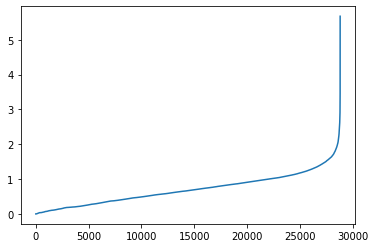

In [18]:
sc_df = preprocessor.fit(data)
dataset = sc_df.transform(data)

neigh = NearestNeighbors()
nbrs = neigh.fit(dataset)
distances, indices = nbrs.kneighbors(dataset)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

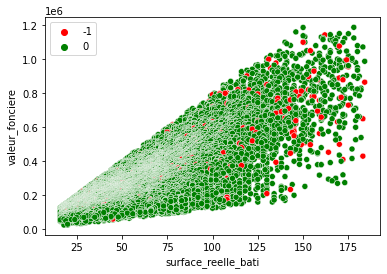

In [19]:


db = DBSCAN(eps = 2.5, min_samples = 30).fit(dataset)

db_predict = db.fit_predict(dataset)

sns.scatterplot(data= data, x= data['surface_reelle_bati'],y= data['valeur_fonciere'], hue = db_predict, palette=["Red", "Green"])

data["cluster"] = db.labels_
data["cluster"].value_counts()
mask = (data["cluster"] == 0)
data = data.loc[mask,:]

In [20]:
data['cluster'].unique()

array([0], dtype=int64)

## MACHINE LEARNING

In [23]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ['surface_reelle_bati','longitude', 'latitude', 'nombre_pieces_principales', \
                'type_local', 'year', 'index_prix', 'closest_school_(m)', 'closest_bakery_(m)', \
                'closest_supermarket_(m)', 'closest_metro_(m)', 'closest_tram_(m)', \
                'annee_construction_dpe', 
                'arrdt_int',
                'diag_dpe_int'
                ]
                
target_variable = 'log_val_fon'

X = data.loc[:,features_list]
Y = data.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
29   12.896717
30   12.816110
31   12.856652
32   12.154779
74   13.270783
Name: log_val_fon, dtype: float64

X :
    surface_reelle_bati  longitude  latitude  nombre_pieces_principales  \
29            65.000000   4.874037 45.749183                   3.000000   
30            66.000000   4.874037 45.749183                   3.000000   
31            69.000000   4.874037 45.749183                   3.000000   
32            42.000000   4.874037 45.749183                   2.000000   
74            73.000000   4.818943 45.771945                   3.000000   

     type_local  year  index_prix  closest_school_(m)  closest_bakery_(m)  \
29  Appartement  2020    6.400000          180.360000          119.650000   
30  Appartement  2022    4.500000          180.360000          119.650000   
31  Appartement  2020    6.400000          180.360000          119.650000   
32  Appartement  2017    4.500000          180.360000          119.650000   


In [24]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['surface_reelle_bati', 'longitude', 'latitude', 'nombre_pieces_principales', 'year', 'index_prix', 'closest_school_(m)', 'closest_bakery_(m)', 'closest_supermarket_(m)', 'closest_metro_(m)', 'closest_tram_(m)', 'annee_construction_dpe', 'arrdt_int', 'diag_dpe_int']
Found categorical features  ['type_local']


In [25]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [26]:
X_test.head(5)

,surface_reelle_bati,longitude,latitude,nombre_pieces_principales,type_local,year,index_prix,closest_school_(m),closest_bakery_(m),closest_supermarket_(m),closest_metro_(m),closest_tram_(m),annee_construction_dpe,arrdt_int,diag_dpe_int
25585,72.000000,4.834253,45.768773,3.000000,Appartement,2019,3.800000,193.800000,154.830000,173.720000,175.170000,1271.530000,1947.000000,1,3
14568,45.000000,4.835637,45.759196,2.000000,Appartement,2017,4.500000,270.820000,125.470000,93.180000,279.270000,531.570000,1969.000000,2,0
24660,81.000000,4.882595,45.747658,4.000000,Appartement,2021,4.600000,269.710000,150.660000,356.850000,600.220000,600.220000,1980.000000,3,4
31758,130.000000,4.807772,45.752536,7.000000,Appartement,2018,3.400000,156.580000,441.950000,1113.460000,1525.640000,1436.570000,1962.000000,5,3
13820,37.000000,4.824510,45.742995,2.000000,Appartement,2020,6.400000,145.190000,217.880000,305.770000,753.800000,229.900000,2009.000000,2,4


In [27]:
Y_test.head(5)

25585   12.628067
14568   11.512925
24660   12.907188
31758   12.767116
13820   12.373758
Name: log_val_fon, dtype: float64

In [28]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

In [29]:
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [30]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [31]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on train set...
       surface_reelle_bati  longitude  latitude  nombre_pieces_principales  \
6059             65.000000   4.842567 45.747787                   2.000000   
28438            49.000000   4.811573 45.757799                   3.000000   
8473             27.000000   4.846397 45.755053                   1.000000   
6368             81.000000   4.825086 45.744554                   3.000000   
17094            75.000000   4.869352 45.756207                   3.000000   

        type_local  year  index_prix  closest_school_(m)  closest_bakery_(m)  \
6059   Appartement  2018    3.300000          248.900000           80.650000   
28438  Appartement  2021    5.100000           72.820000           45.470000   
8473   Appartement  2019    4.300000           72.550000           59.590000   
6368   Appartement  2019    5.300000          179.110000          189.900000   
17094  Appartement  2019    4.000000           95.250000          160.190000   

       c

## Testing several models

In [35]:
# The best and last model was XGBoostRegressor (these hyperparameters were fine tuned after a gridsearch)
xgboostreg = XGBRegressor(max_depth=8, min_child_weight=8, n_estimators=66)


# Below, this is the whole list of models we've compared 

#ada_regressor = AdaBoostRegressor()    
#extra_trees_reg = ExtraTreesRegressor(min_samples_leaf=1, min_samples_split=5, n_estimators=152)     
#random_for_reg = RandomForestRegressor(max_depth=70, min_samples_leaf=1, min_samples_split=3, n_estimators=100)
#grad_boost_reg = GradientBoostingRegressor()
#voting = VotingRegressor([('extra', extra_trees_reg), ('rfr', random_for_reg)])
#bagg_reg = BaggingRegressor()
#stack = StackingRegressor([('extra', extra_trees_reg), ('rfr', random_for_reg)])
#kn = KNeighborsRegressor()
#ridge_cv = RidgeCV()
#sgdreg = SGDRegressor()
#lassocv = LassoCV()
#linearsvr = LinearSVR()
#svr = SVR()
#linear = LinearRegression()
#logreg = LogisticRegression()

list_models = [
    #extra_trees_reg, 
    #random_for_reg, 
    #voting, 
    xgboostreg,
    #bagg_reg, 
    # stack, 
    #kn,
    #ridge_cv,
    #sgdreg,
    #lassocv,
    #linearsvr,
    #svr,
    #linear,
    #logreg

    ]

In [36]:
scores_df = pd.DataFrame(columns = ['model', 'r2_score_train', 'r2_score_test', 'MAPE_train', 'MAPE_test', 'surface_max', 'surface_min', 'prix_min', 'prix_max', 'prix_m2_mini', 'prix_m2_max'])
df_ytest = pd.DataFrame()
scores_df.index = scores_df.index + 1

for model in list_models:
    model = model
    name_model = str(model.__class__).split(".")[-1][:-2]
    model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    print()
    print(f"R2 score de {name_model} on training set : ", r2_score(Y_train, Y_train_pred))
    print(f"R2 score de {name_model} on test set : ", r2_score(Y_test, Y_test_pred))
    scores_df = scores_df.append({'model': name_model, \
    'r2_score_train': r2_score(Y_train, Y_train_pred), \
    'r2_score_test': r2_score(Y_test, Y_test_pred), \
    'MAPE_train': mean_absolute_percentage_error(Y_train, Y_train_pred), \
    'MAPE_test': mean_absolute_percentage_error(Y_test, Y_test_pred),\
    'surface_max': surface_max ,\
    'surface_min': surface_min ,\
    'prix_min' : prix_min,\
    'prix_max' : prix_max,\
    'prix_m2_mini' : prix_m2_mini,\
    'prix_m2_max' : prix_m2_max},    
    ignore_index = True)

df_ytest['list_index'] = Y_test.index
df_ytest['ytest'] = Y_test.values
df_ytest['ytest_pred'] = Y_test_pred
df_ytest['ytest_real'] = df_ytest['ytest'].apply(lambda x : np.exp(x))
df_ytest['ytest_pred_real'] = df_ytest['ytest_pred'].apply(lambda x : np.exp(x))
#save the model to disk
# filename = f'model_recorded/model_{name_model}.sav'
# joblib.dump(model, filename)


scores_df = scores_df.sort_values(by='r2_score_test', ascending=False)
scores_df.head(10)


R2 score de XGBRegressor on training set :  0.909834202365567
R2 score de XGBRegressor on test set :  0.8305568887002979


,model,r2_score_train,r2_score_test,MAPE_train,MAPE_test,surface_max,surface_min,prix_min,prix_max,prix_m2_mini,prix_m2_max
0,XGBRegressor,0.909834,0.830557,0.009315,0.012510,185.000000,15.000000,4000.000000,1200000.000000,1200.000000,8000.000000


In [37]:
timestr = time.strftime("%Y%m%d-%H%M%S")
scores_df.to_csv(f'save_output/{timestr}-test_models.csv', index=False)

## Watching on our results to explore the distance between true and predict values

In [38]:
df_ytest.head()

,list_index,ytest,ytest_pred,ytest_real,ytest_pred_real
0,25585,12.628067,12.642311,305000.000000,309375.520953
1,14568,11.512925,12.096234,100000.000000,179195.796388
2,24660,12.907188,12.843289,403200.000000,378241.959873
3,31758,12.767116,12.827854,350500.000000,372448.538840
4,13820,12.373758,12.312455,236512.900000,222449.453012


In [39]:
df_ytest['result'] = abs(df_ytest['ytest_pred_real'] - df_ytest['ytest_real'])
# df_ytest.to_csv('save_output/tab_y_test.csv', index=False)

In [40]:
df_ytest.head()

,list_index,ytest,ytest_pred,ytest_real,ytest_pred_real,result
0,25585,12.628067,12.642311,305000.000000,309375.520953,4375.520953
1,14568,11.512925,12.096234,100000.000000,179195.796388,79195.796388
2,24660,12.907188,12.843289,403200.000000,378241.959873,24958.040127
3,31758,12.767116,12.827854,350500.000000,372448.538840,21948.538840
4,13820,12.373758,12.312455,236512.900000,222449.453012,14063.446988


In [41]:
shape = []

for value in df_ytest['result']:
    if value <= 40000.0:
        shape.append('acceptable_<_40k')
    else:
        shape.append('incorrect_>_40k')

df_ytest['shape_error'] = shape


In [42]:
len(Y_test)

5692

In [43]:
df_ytest['shape_error'].value_counts()

acceptable_<_40k    3750
incorrect_>_40k     1942
Name: shape_error, dtype: int64

In [44]:
df_ytest['shape_error'].value_counts(normalize=True) 

acceptable_<_40k   0.658819
incorrect_>_40k    0.341181
Name: shape_error, dtype: float64

In [45]:
shape = []

for value in df_ytest['result']:
    if value <= 40000.0:
        shape.append('inf_40k')
    else:
        shape.append('sup_40k')

df_ytest['shape_error'] = shape

In [46]:
shape = []

for value in df_ytest['result']:
    if value < 10000.0:
        shape.append('inf_10k')
    elif value < 20000.0:
        shape.append('inf_20k')
    elif value < 30000.0:
        shape.append('inf_30k')
    elif value < 40000.0:
        shape.append('inf_40k')
    else:
        shape.append('sup_40k')

df_ytest['distance_btw_pred_and_true'] = shape

In [47]:
df_ytest['distance_btw_pred_and_true'].value_counts(normalize=True)

sup_40k   0.341181
inf_10k   0.216093
inf_20k   0.190970
inf_30k   0.139143
inf_40k   0.112614
Name: distance_btw_pred_and_true, dtype: float64

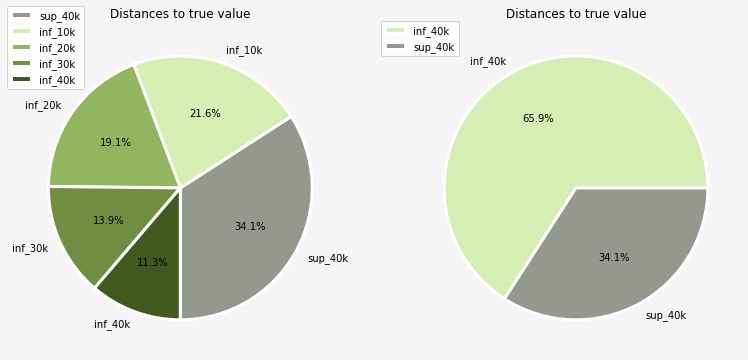

In [48]:
fig = plt.figure(figsize=(13,13), facecolor='whitesmoke')

colors1 = ['#94988e','#d6eeb3', '#92b55f', '#6f8e41', '#41591f']
colors2 = ['#d6eeb3', '#94988e']

labels1 = 'sup_40k', 'inf_10k', 'inf_20k', 'inf_30k', 'inf_40k'
labels2 = 'inf_40k', 'sup_40k'

size1 = df_ytest['distance_btw_pred_and_true'].value_counts()
size2 = df_ytest['shape_error'].value_counts()

plt.subplot(1,2,1)
plt.pie(size1, labels=labels1, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },\
      autopct='%1.1f%%', startangle=270, colors=colors1)
plt.title('Distances to true value', fontdict={'color':'black'})
plt.legend(loc=(-0.025,0.8))

plt.subplot(1,2,2)
plt.pie(size2, labels=labels2, autopct='%1.1f%%', \
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, colors=colors2)
plt.title('Distances to true value', fontdict={'color':'black'})
plt.legend(loc=(-0.09,0.9))


plt.show()